# Social Network Analysis group project 📊

***

## Group members 👥
- Michele Turco
- Simone Filosofi
- Edoardo Cocciò
- Lorenzo Laterza

In [3]:
import networkx as nx
import pandas as pd
import matplotlib.pyplot as plt
import json

In [4]:
nodes_df = pd.read_csv('data/nodes.csv', index_col=0,sep = ',')
edges_df = pd.read_csv('data/edges.csv')

nodes_df[' viz'] = nodes_df[' viz'].apply(lambda row: row.replace("'", '"')).apply(json.loads)
nodes_df['size'] = nodes_df[' viz'].apply(lambda row: row['size'] * 20)

nodes_df[' _pos'] = nodes_df[' _pos'].apply(lambda row: (float(row[7:18]), float(row[20:-2])))

In [5]:
links = edges_df['coordinates'] = edges_df.apply(lambda row: (row['# source'], row[' target'], row[' weight']), axis=1)

labels = enumerate(nodes_df[' label'])
labels = dict(labels)

pos = nodes_df[' _pos']

colors = []
for n in range(0,94):
    color = nodes_df[' viz'][n]['color']
    accepted_format = (color['r']/255, color['g']/255, color['b']/255, color['a'])
    colors.append(accepted_format)

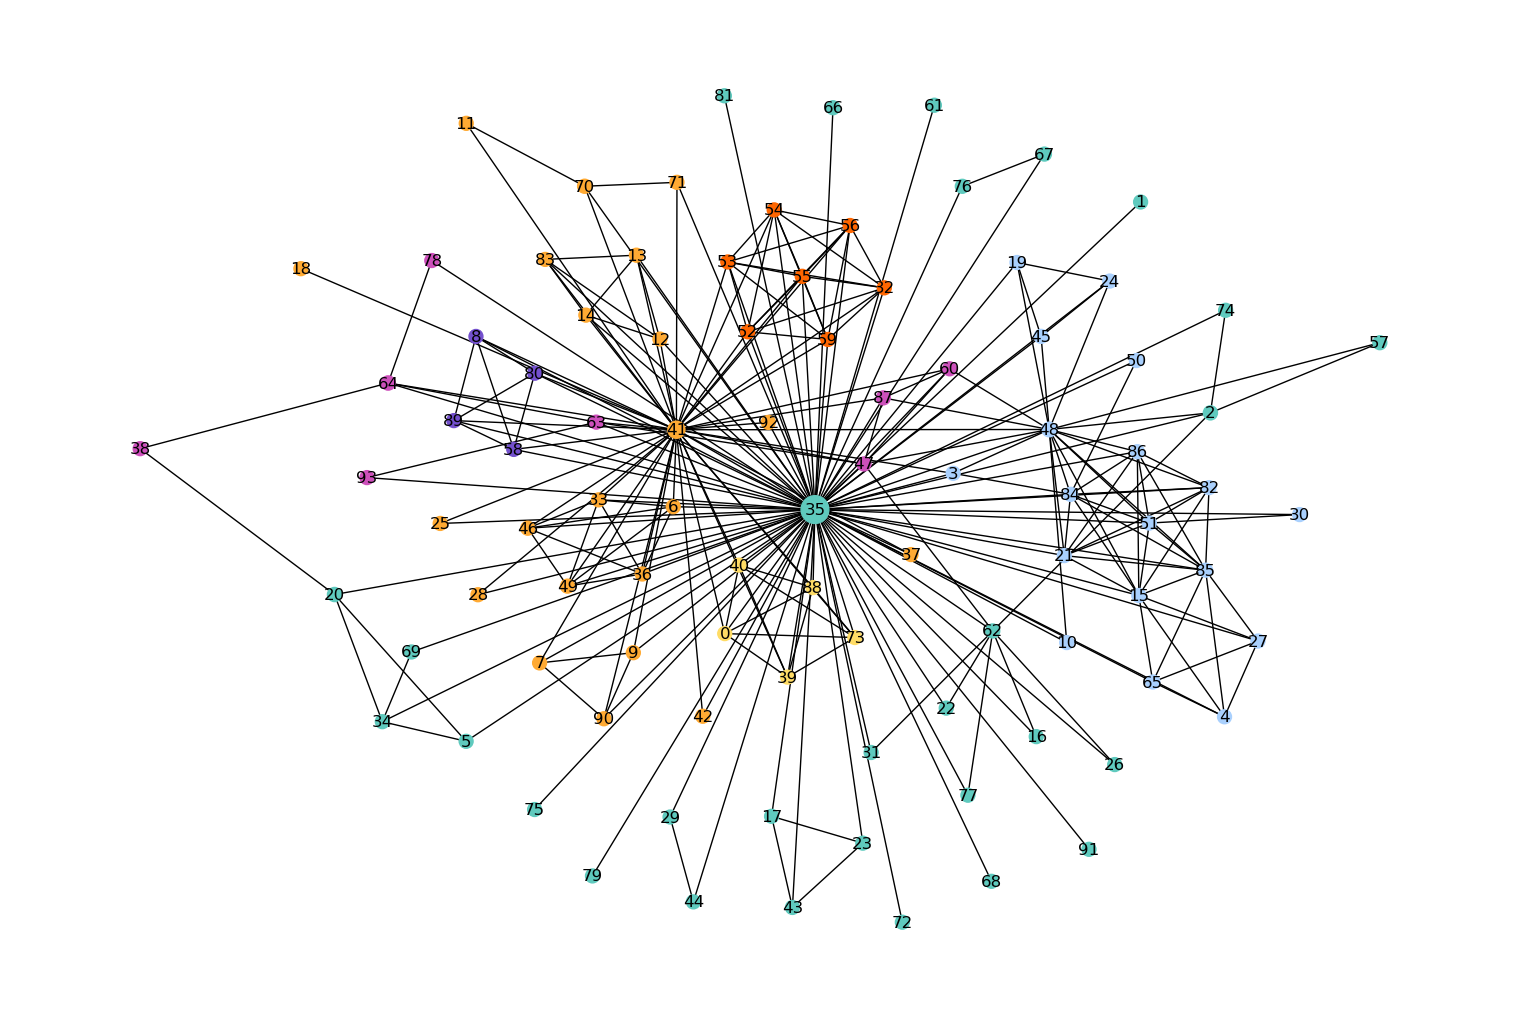

In [6]:
plt.figure(figsize=(15, 10))
G = nx.Graph()

for n in range(0, len(nodes_df)):
    G.add_node(n)

G.add_weighted_edges_from(links)
nx.set_node_attributes(G, labels, name = 'label')


nx.draw(G, node_size = nodes_df['size'], pos = pos, with_labels = True, node_color = colors)

### Number of nodes

In [7]:
G.number_of_nodes()

94

### Number of edges

In [8]:
G.number_of_edges()

271

### Density

In [9]:
nx.density(G)

0.06199954243880119

### Checking what's the largest component of the graph
Since all nodes are connected we are considering the entire graph for the following computations

In [15]:
cc = [i for i in nx.connected_components(G)]
len(cc)

1

### Diameter

In [11]:
nx.diameter(G)

4

### Average Shortest Path Length

In [12]:
nx.average_shortest_path_length(G)

1.9949668268130862

### Average Clustering

In [13]:
nx.average_clustering(G)

0.8002425574908809

### Transitivity implementation using basic networkx functions

In [14]:
# T = 3 * (Number of triangles) / ( N(N-1) / 2 )

def transitivity(G):
# Actual number of triangles is 'triangles'/3, but the denominator semplifies with the '3' in the main formula

    triangles = sum(nx.triangles(G).values())
    sum_of_degrees = 0

    for node in G.nodes():
        fraction = (G.degree(node) * (G.degree(node) - 1))/2
        sum_of_degrees += fraction

    return triangles / sum_of_degrees

print(f"Transitivity results:\n---------------------------------------  \nOur implementation: {transitivity(G)} \nNetworkx: {nx.transitivity(G)}")


Transitivity results:
---------------------------------------  
Our implementation: 0.1918081918081918 
Networkx: 0.1918081918081918
